# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 36kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

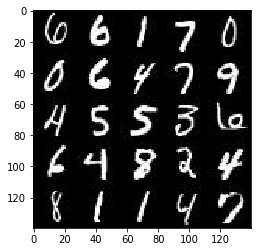

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

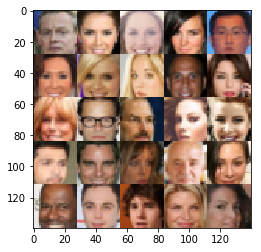

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, filters=128, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, filters=256, kernel_size=5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Unpack data_shape
    _, image_width, image_height, image_channels = data_shape
    
    # model_inputs(image_width, image_height, image_channels, z_dim):
    inputs_real, inputs_z, model_lr = model_inputs(image_width, image_height, image_channels, z_dim)

    # model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)

    # model_opt(d_loss, g_loss, learning_rate, beta1):
    d_opt, g_opt = model_opt(d_loss, g_loss, model_lr, beta1)
    
    steps = 0
    show_every = 100
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, model_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, model_lr: learning_rate})
                
                if steps % print_every == 0:
                     # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_real: batch_images, inputs_z: batch_z})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    # show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
                    show_generator_output(sess, show_n_images, inputs_z, image_channels, data_image_mode)
                
                

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.4275... Generator Loss: 0.0979
Epoch 1/2... Discriminator Loss: 0.0365... Generator Loss: 5.5041
Epoch 1/2... Discriminator Loss: 0.7776... Generator Loss: 18.4475
Epoch 1/2... Discriminator Loss: 0.5642... Generator Loss: 14.7585
Epoch 1/2... Discriminator Loss: 0.1194... Generator Loss: 5.5378
Epoch 1/2... Discriminator Loss: 0.9159... Generator Loss: 3.8778
Epoch 1/2... Discriminator Loss: 0.3076... Generator Loss: 2.5870
Epoch 1/2... Discriminator Loss: 0.3292... Generator Loss: 1.9283
Epoch 1/2... Discriminator Loss: 0.2272... Generator Loss: 2.7466
Epoch 1/2... Discriminator Loss: 0.2920... Generator Loss: 2.0828


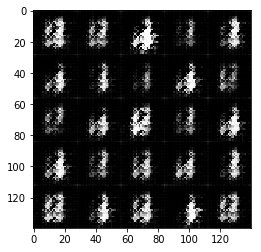

Epoch 1/2... Discriminator Loss: 0.1281... Generator Loss: 4.0405
Epoch 1/2... Discriminator Loss: 0.4583... Generator Loss: 3.0176
Epoch 1/2... Discriminator Loss: 0.4324... Generator Loss: 3.6470
Epoch 1/2... Discriminator Loss: 0.2470... Generator Loss: 2.6377
Epoch 1/2... Discriminator Loss: 0.4425... Generator Loss: 4.6719
Epoch 1/2... Discriminator Loss: 0.1022... Generator Loss: 3.4567
Epoch 1/2... Discriminator Loss: 0.1367... Generator Loss: 3.2277
Epoch 1/2... Discriminator Loss: 0.3471... Generator Loss: 3.3789
Epoch 1/2... Discriminator Loss: 0.3149... Generator Loss: 3.1858
Epoch 1/2... Discriminator Loss: 0.3507... Generator Loss: 6.4443


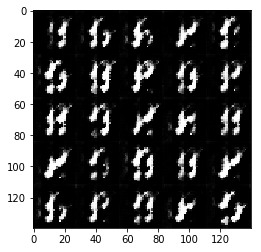

Epoch 1/2... Discriminator Loss: 0.3945... Generator Loss: 2.1188
Epoch 1/2... Discriminator Loss: 0.0813... Generator Loss: 4.6411
Epoch 1/2... Discriminator Loss: 0.2099... Generator Loss: 2.5337
Epoch 1/2... Discriminator Loss: 0.3504... Generator Loss: 1.8744
Epoch 1/2... Discriminator Loss: 0.2846... Generator Loss: 2.3260
Epoch 1/2... Discriminator Loss: 0.1090... Generator Loss: 3.1589
Epoch 1/2... Discriminator Loss: 0.2802... Generator Loss: 2.8525
Epoch 1/2... Discriminator Loss: 0.7209... Generator Loss: 2.2235
Epoch 1/2... Discriminator Loss: 0.3274... Generator Loss: 2.9285
Epoch 1/2... Discriminator Loss: 0.2009... Generator Loss: 2.5199


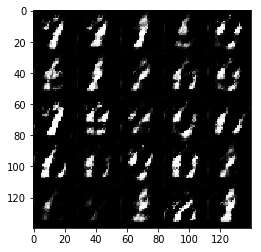

Epoch 1/2... Discriminator Loss: 0.3734... Generator Loss: 1.6909
Epoch 1/2... Discriminator Loss: 0.3087... Generator Loss: 2.5545
Epoch 1/2... Discriminator Loss: 1.0850... Generator Loss: 1.0647
Epoch 1/2... Discriminator Loss: 0.2457... Generator Loss: 2.7896
Epoch 1/2... Discriminator Loss: 0.3284... Generator Loss: 3.0762
Epoch 1/2... Discriminator Loss: 0.2762... Generator Loss: 2.7852
Epoch 1/2... Discriminator Loss: 0.3416... Generator Loss: 2.2785
Epoch 1/2... Discriminator Loss: 0.7975... Generator Loss: 1.1396
Epoch 1/2... Discriminator Loss: 0.4903... Generator Loss: 1.7846
Epoch 1/2... Discriminator Loss: 0.5982... Generator Loss: 1.3721


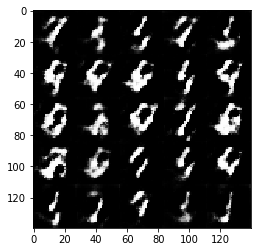

Epoch 1/2... Discriminator Loss: 0.6586... Generator Loss: 1.4146
Epoch 1/2... Discriminator Loss: 0.5191... Generator Loss: 1.8873
Epoch 1/2... Discriminator Loss: 0.6691... Generator Loss: 1.5996
Epoch 1/2... Discriminator Loss: 0.8250... Generator Loss: 1.0495
Epoch 1/2... Discriminator Loss: 0.6401... Generator Loss: 1.5470
Epoch 1/2... Discriminator Loss: 0.4431... Generator Loss: 1.7452
Epoch 1/2... Discriminator Loss: 0.8098... Generator Loss: 1.1704
Epoch 1/2... Discriminator Loss: 0.4047... Generator Loss: 2.7655
Epoch 1/2... Discriminator Loss: 0.4795... Generator Loss: 1.5092
Epoch 1/2... Discriminator Loss: 0.7943... Generator Loss: 1.0305


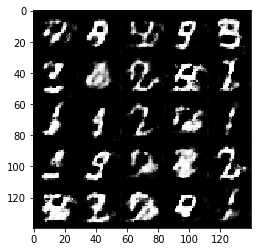

Epoch 1/2... Discriminator Loss: 0.3001... Generator Loss: 2.7349
Epoch 1/2... Discriminator Loss: 0.5961... Generator Loss: 3.4818
Epoch 1/2... Discriminator Loss: 0.4520... Generator Loss: 2.7989
Epoch 1/2... Discriminator Loss: 0.3490... Generator Loss: 2.2610
Epoch 1/2... Discriminator Loss: 0.4462... Generator Loss: 2.4464
Epoch 1/2... Discriminator Loss: 0.4494... Generator Loss: 2.1473
Epoch 1/2... Discriminator Loss: 0.8787... Generator Loss: 0.9149
Epoch 1/2... Discriminator Loss: 0.8245... Generator Loss: 0.9794
Epoch 1/2... Discriminator Loss: 0.5242... Generator Loss: 1.5451
Epoch 1/2... Discriminator Loss: 0.8343... Generator Loss: 1.0938


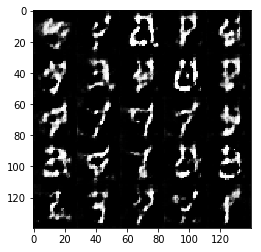

Epoch 1/2... Discriminator Loss: 0.8874... Generator Loss: 0.8988
Epoch 1/2... Discriminator Loss: 1.1205... Generator Loss: 0.7437
Epoch 1/2... Discriminator Loss: 1.0061... Generator Loss: 1.0826
Epoch 1/2... Discriminator Loss: 0.5738... Generator Loss: 1.4138
Epoch 1/2... Discriminator Loss: 0.6296... Generator Loss: 2.3756
Epoch 1/2... Discriminator Loss: 0.6525... Generator Loss: 1.6601
Epoch 1/2... Discriminator Loss: 0.7543... Generator Loss: 2.4890
Epoch 1/2... Discriminator Loss: 0.8343... Generator Loss: 0.9149
Epoch 1/2... Discriminator Loss: 0.5921... Generator Loss: 1.3856
Epoch 1/2... Discriminator Loss: 0.5775... Generator Loss: 2.0575


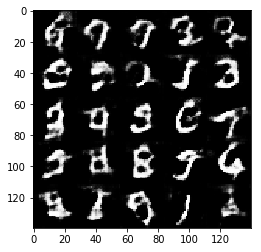

Epoch 1/2... Discriminator Loss: 0.8412... Generator Loss: 0.8995
Epoch 1/2... Discriminator Loss: 0.9958... Generator Loss: 2.5614
Epoch 1/2... Discriminator Loss: 0.6960... Generator Loss: 1.2522
Epoch 1/2... Discriminator Loss: 0.6691... Generator Loss: 1.1416
Epoch 1/2... Discriminator Loss: 0.9200... Generator Loss: 2.8974
Epoch 1/2... Discriminator Loss: 0.7710... Generator Loss: 2.1265
Epoch 1/2... Discriminator Loss: 0.9395... Generator Loss: 0.8437
Epoch 1/2... Discriminator Loss: 0.7370... Generator Loss: 0.9977
Epoch 1/2... Discriminator Loss: 1.6222... Generator Loss: 4.2015
Epoch 1/2... Discriminator Loss: 0.7315... Generator Loss: 1.8743


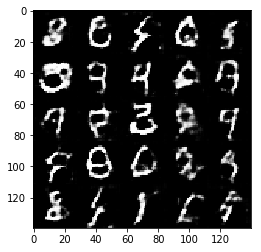

Epoch 1/2... Discriminator Loss: 0.4813... Generator Loss: 1.5436
Epoch 1/2... Discriminator Loss: 0.8083... Generator Loss: 0.9238
Epoch 1/2... Discriminator Loss: 0.7919... Generator Loss: 1.0826
Epoch 1/2... Discriminator Loss: 0.9386... Generator Loss: 2.4773
Epoch 1/2... Discriminator Loss: 0.8298... Generator Loss: 2.9665
Epoch 1/2... Discriminator Loss: 0.6747... Generator Loss: 2.1113
Epoch 1/2... Discriminator Loss: 0.7569... Generator Loss: 2.6349
Epoch 1/2... Discriminator Loss: 0.6281... Generator Loss: 1.6899
Epoch 1/2... Discriminator Loss: 0.7065... Generator Loss: 1.4989
Epoch 1/2... Discriminator Loss: 0.7314... Generator Loss: 1.5046


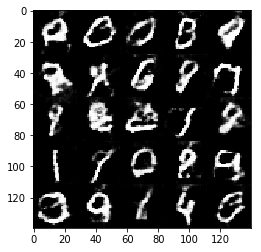

Epoch 1/2... Discriminator Loss: 0.6227... Generator Loss: 2.1353
Epoch 1/2... Discriminator Loss: 0.6999... Generator Loss: 2.7479
Epoch 1/2... Discriminator Loss: 1.0021... Generator Loss: 0.8233
Epoch 2/2... Discriminator Loss: 0.7014... Generator Loss: 1.2605
Epoch 2/2... Discriminator Loss: 1.2998... Generator Loss: 3.3349
Epoch 2/2... Discriminator Loss: 0.7347... Generator Loss: 1.0299
Epoch 2/2... Discriminator Loss: 0.8003... Generator Loss: 0.9486
Epoch 2/2... Discriminator Loss: 0.8305... Generator Loss: 2.3834
Epoch 2/2... Discriminator Loss: 0.7525... Generator Loss: 1.0661
Epoch 2/2... Discriminator Loss: 0.8573... Generator Loss: 0.9814


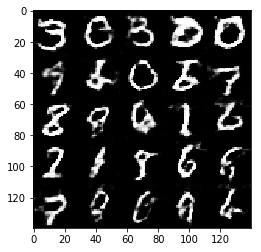

Epoch 2/2... Discriminator Loss: 0.6698... Generator Loss: 2.2368
Epoch 2/2... Discriminator Loss: 0.7879... Generator Loss: 1.4188
Epoch 2/2... Discriminator Loss: 1.1092... Generator Loss: 3.3464
Epoch 2/2... Discriminator Loss: 1.1720... Generator Loss: 3.0200
Epoch 2/2... Discriminator Loss: 0.7085... Generator Loss: 1.4817
Epoch 2/2... Discriminator Loss: 0.9402... Generator Loss: 0.9319
Epoch 2/2... Discriminator Loss: 1.3386... Generator Loss: 0.4650
Epoch 2/2... Discriminator Loss: 0.8034... Generator Loss: 1.2973
Epoch 2/2... Discriminator Loss: 0.8533... Generator Loss: 1.0433
Epoch 2/2... Discriminator Loss: 0.8852... Generator Loss: 0.9427


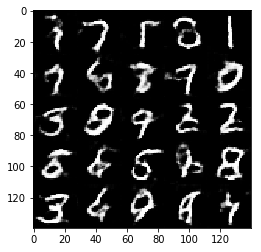

Epoch 2/2... Discriminator Loss: 0.7525... Generator Loss: 1.6563
Epoch 2/2... Discriminator Loss: 0.6448... Generator Loss: 1.6037
Epoch 2/2... Discriminator Loss: 0.6268... Generator Loss: 1.7497
Epoch 2/2... Discriminator Loss: 1.0274... Generator Loss: 2.8701
Epoch 2/2... Discriminator Loss: 1.0755... Generator Loss: 0.6478
Epoch 2/2... Discriminator Loss: 1.0388... Generator Loss: 1.4504
Epoch 2/2... Discriminator Loss: 0.7674... Generator Loss: 1.0938
Epoch 2/2... Discriminator Loss: 0.7685... Generator Loss: 2.1297
Epoch 2/2... Discriminator Loss: 0.9409... Generator Loss: 2.0350
Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 1.0338


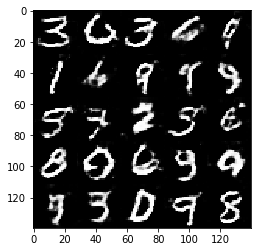

Epoch 2/2... Discriminator Loss: 0.8109... Generator Loss: 0.8921
Epoch 2/2... Discriminator Loss: 0.6614... Generator Loss: 1.9659
Epoch 2/2... Discriminator Loss: 0.7603... Generator Loss: 1.0160
Epoch 2/2... Discriminator Loss: 1.3073... Generator Loss: 0.5591
Epoch 2/2... Discriminator Loss: 0.7761... Generator Loss: 1.1623
Epoch 2/2... Discriminator Loss: 0.7967... Generator Loss: 1.0494
Epoch 2/2... Discriminator Loss: 0.9474... Generator Loss: 0.7334
Epoch 2/2... Discriminator Loss: 0.6582... Generator Loss: 1.3998
Epoch 2/2... Discriminator Loss: 1.3190... Generator Loss: 0.5096
Epoch 2/2... Discriminator Loss: 0.8058... Generator Loss: 0.8824


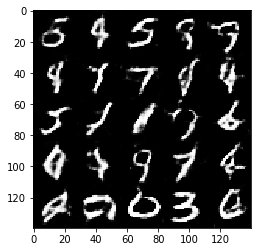

Epoch 2/2... Discriminator Loss: 0.7337... Generator Loss: 1.0540
Epoch 2/2... Discriminator Loss: 0.7212... Generator Loss: 1.1577
Epoch 2/2... Discriminator Loss: 0.6470... Generator Loss: 1.7581
Epoch 2/2... Discriminator Loss: 0.9064... Generator Loss: 1.0196
Epoch 2/2... Discriminator Loss: 0.8102... Generator Loss: 0.9773
Epoch 2/2... Discriminator Loss: 0.6251... Generator Loss: 1.2041
Epoch 2/2... Discriminator Loss: 0.6662... Generator Loss: 1.0330
Epoch 2/2... Discriminator Loss: 1.7590... Generator Loss: 3.7452
Epoch 2/2... Discriminator Loss: 0.7098... Generator Loss: 1.4243
Epoch 2/2... Discriminator Loss: 0.8377... Generator Loss: 0.7923


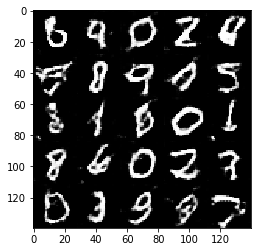

Epoch 2/2... Discriminator Loss: 1.3679... Generator Loss: 0.3824
Epoch 2/2... Discriminator Loss: 0.5744... Generator Loss: 1.5690
Epoch 2/2... Discriminator Loss: 0.6786... Generator Loss: 0.9928
Epoch 2/2... Discriminator Loss: 0.9463... Generator Loss: 0.7014
Epoch 2/2... Discriminator Loss: 1.6748... Generator Loss: 0.2938
Epoch 2/2... Discriminator Loss: 0.8632... Generator Loss: 0.8643
Epoch 2/2... Discriminator Loss: 0.6519... Generator Loss: 1.9503
Epoch 2/2... Discriminator Loss: 0.6576... Generator Loss: 1.1296
Epoch 2/2... Discriminator Loss: 0.6125... Generator Loss: 1.4618
Epoch 2/2... Discriminator Loss: 1.2683... Generator Loss: 0.6851


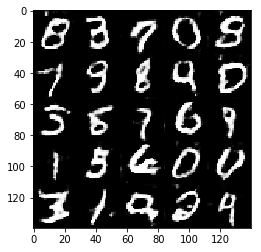

Epoch 2/2... Discriminator Loss: 1.5625... Generator Loss: 0.3816
Epoch 2/2... Discriminator Loss: 0.7018... Generator Loss: 1.0068
Epoch 2/2... Discriminator Loss: 0.7555... Generator Loss: 0.9580
Epoch 2/2... Discriminator Loss: 0.9091... Generator Loss: 1.4019
Epoch 2/2... Discriminator Loss: 0.7414... Generator Loss: 1.1200
Epoch 2/2... Discriminator Loss: 0.6787... Generator Loss: 1.5499
Epoch 2/2... Discriminator Loss: 0.9653... Generator Loss: 0.7108
Epoch 2/2... Discriminator Loss: 0.6791... Generator Loss: 1.1643
Epoch 2/2... Discriminator Loss: 0.9202... Generator Loss: 0.7843
Epoch 2/2... Discriminator Loss: 0.8554... Generator Loss: 0.8030


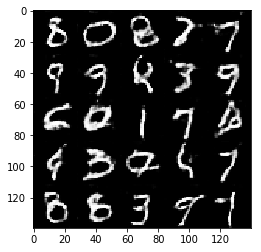

Epoch 2/2... Discriminator Loss: 0.7229... Generator Loss: 1.2679
Epoch 2/2... Discriminator Loss: 1.4355... Generator Loss: 0.3945
Epoch 2/2... Discriminator Loss: 0.5535... Generator Loss: 1.6924
Epoch 2/2... Discriminator Loss: 0.7587... Generator Loss: 1.8750
Epoch 2/2... Discriminator Loss: 0.7852... Generator Loss: 0.8373
Epoch 2/2... Discriminator Loss: 1.0724... Generator Loss: 0.5649
Epoch 2/2... Discriminator Loss: 1.0189... Generator Loss: 0.5789
Epoch 2/2... Discriminator Loss: 0.8948... Generator Loss: 0.9088
Epoch 2/2... Discriminator Loss: 0.5269... Generator Loss: 1.2985
Epoch 2/2... Discriminator Loss: 2.0930... Generator Loss: 0.2822


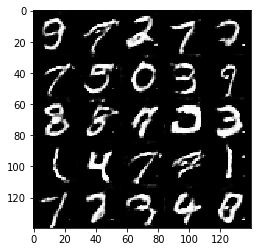

Epoch 2/2... Discriminator Loss: 1.2501... Generator Loss: 0.4776
Epoch 2/2... Discriminator Loss: 0.7397... Generator Loss: 1.3811
Epoch 2/2... Discriminator Loss: 0.9034... Generator Loss: 1.2811
Epoch 2/2... Discriminator Loss: 0.5630... Generator Loss: 1.3896
Epoch 2/2... Discriminator Loss: 0.8022... Generator Loss: 0.8989
Epoch 2/2... Discriminator Loss: 1.1497... Generator Loss: 0.5812
Epoch 2/2... Discriminator Loss: 0.7933... Generator Loss: 0.9062
Epoch 2/2... Discriminator Loss: 2.2316... Generator Loss: 0.3111
Epoch 2/2... Discriminator Loss: 0.8885... Generator Loss: 0.8165
Epoch 2/2... Discriminator Loss: 0.9329... Generator Loss: 1.8223


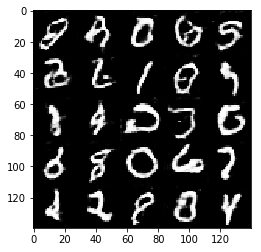

Epoch 2/2... Discriminator Loss: 0.5696... Generator Loss: 1.3678
Epoch 2/2... Discriminator Loss: 1.2261... Generator Loss: 0.4741
Epoch 2/2... Discriminator Loss: 0.4527... Generator Loss: 1.5249
Epoch 2/2... Discriminator Loss: 2.2565... Generator Loss: 0.2281
Epoch 2/2... Discriminator Loss: 0.6462... Generator Loss: 1.2283
Epoch 2/2... Discriminator Loss: 0.8692... Generator Loss: 0.7757
Epoch 2/2... Discriminator Loss: 1.0352... Generator Loss: 2.3188


In [12]:
batch_size = 64
z_dim = 128 
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3285... Generator Loss: 4.7859
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 15.2990
Epoch 1/1... Discriminator Loss: 0.0582... Generator Loss: 10.8597
Epoch 1/1... Discriminator Loss: 0.1556... Generator Loss: 2.8745
Epoch 1/1... Discriminator Loss: 0.2948... Generator Loss: 3.7916
Epoch 1/1... Discriminator Loss: 2.1553... Generator Loss: 0.1557
Epoch 1/1... Discriminator Loss: 0.6049... Generator Loss: 3.1851
Epoch 1/1... Discriminator Loss: 1.5369... Generator Loss: 6.6196
Epoch 1/1... Discriminator Loss: 0.6533... Generator Loss: 2.4534
Epoch 1/1... Discriminator Loss: 0.7006... Generator Loss: 1.0307


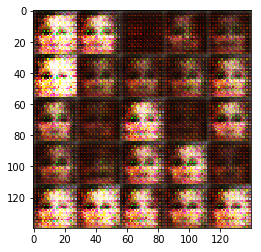

Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 5.8176
Epoch 1/1... Discriminator Loss: 0.3478... Generator Loss: 2.2147
Epoch 1/1... Discriminator Loss: 0.2847... Generator Loss: 1.8003
Epoch 1/1... Discriminator Loss: 0.3752... Generator Loss: 2.3677
Epoch 1/1... Discriminator Loss: 0.2792... Generator Loss: 2.9708
Epoch 1/1... Discriminator Loss: 0.3771... Generator Loss: 2.2567
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 5.3502
Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 1.7382
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.3170
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 0.9198


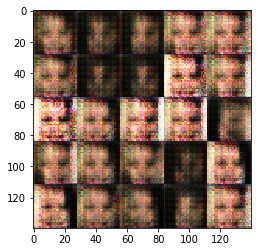

Epoch 1/1... Discriminator Loss: 0.3400... Generator Loss: 3.3191
Epoch 1/1... Discriminator Loss: 1.6127... Generator Loss: 0.3229
Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 2.2650
Epoch 1/1... Discriminator Loss: 1.9366... Generator Loss: 0.3330
Epoch 1/1... Discriminator Loss: 1.6169... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 1.5759
Epoch 1/1... Discriminator Loss: 0.7310... Generator Loss: 1.4695
Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 1.0645


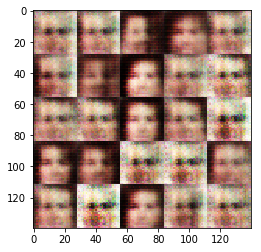

Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 1.1800
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.8957
Epoch 1/1... Discriminator Loss: 0.8594... Generator Loss: 1.7632
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 1.9712
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 1.0298
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.4971
Epoch 1/1... Discriminator Loss: 0.9081... Generator Loss: 1.4543


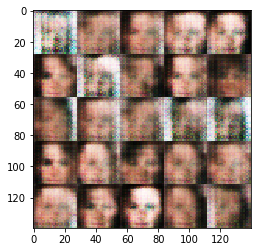

Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 1.2657
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 2.1728
Epoch 1/1... Discriminator Loss: 0.9860... Generator Loss: 1.5028
Epoch 1/1... Discriminator Loss: 0.8396... Generator Loss: 1.2164
Epoch 1/1... Discriminator Loss: 0.8656... Generator Loss: 1.1370
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 1.6936
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.9914
Epoch 1/1... Discriminator Loss: 0.4382... Generator Loss: 2.1708
Epoch 1/1... Discriminator Loss: 0.8817... Generator Loss: 0.9959


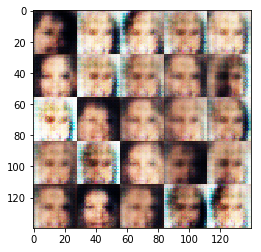

Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.9117
Epoch 1/1... Discriminator Loss: 0.7281... Generator Loss: 1.3219
Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 0.7450... Generator Loss: 1.6973
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.6753... Generator Loss: 3.3612
Epoch 1/1... Discriminator Loss: 0.7200... Generator Loss: 1.3660
Epoch 1/1... Discriminator Loss: 0.6544... Generator Loss: 1.3115
Epoch 1/1... Discriminator Loss: 0.7650... Generator Loss: 1.3364
Epoch 1/1... Discriminator Loss: 0.6374... Generator Loss: 2.2499


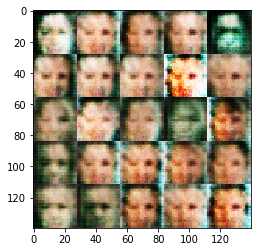

Epoch 1/1... Discriminator Loss: 0.9797... Generator Loss: 1.5129
Epoch 1/1... Discriminator Loss: 0.6537... Generator Loss: 1.7770
Epoch 1/1... Discriminator Loss: 0.7498... Generator Loss: 1.1428
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 1.6895
Epoch 1/1... Discriminator Loss: 0.6925... Generator Loss: 2.2708
Epoch 1/1... Discriminator Loss: 0.8027... Generator Loss: 1.4798
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 0.6256... Generator Loss: 2.7865
Epoch 1/1... Discriminator Loss: 0.6590... Generator Loss: 1.3096
Epoch 1/1... Discriminator Loss: 0.6283... Generator Loss: 1.9389


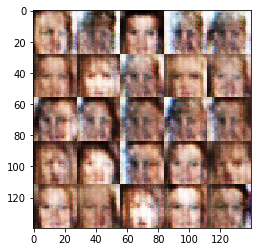

Epoch 1/1... Discriminator Loss: 1.9109... Generator Loss: 0.2635
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.5365
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 2.0835
Epoch 1/1... Discriminator Loss: 0.6557... Generator Loss: 1.3641
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 1.6166
Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 1.3152
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 1.0948
Epoch 1/1... Discriminator Loss: 0.8420... Generator Loss: 1.4907
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 4.0417


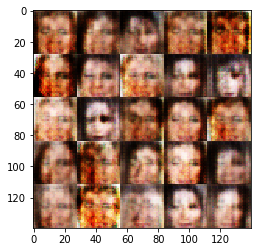

Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 0.6999... Generator Loss: 1.9747
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 0.8050... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 2.3880
Epoch 1/1... Discriminator Loss: 0.8731... Generator Loss: 1.5971
Epoch 1/1... Discriminator Loss: 0.8758... Generator Loss: 1.5754
Epoch 1/1... Discriminator Loss: 0.8307... Generator Loss: 1.0537
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 0.8550


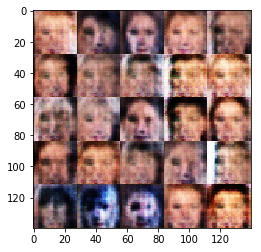

Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.4744
Epoch 1/1... Discriminator Loss: 0.8982... Generator Loss: 2.2029
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.4574
Epoch 1/1... Discriminator Loss: 0.9020... Generator Loss: 0.9510
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.5772
Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 1.0349
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 1.3841
Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 2.2006


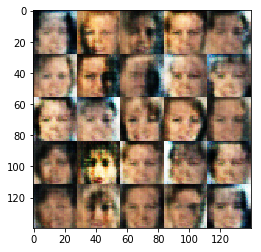

Epoch 1/1... Discriminator Loss: 0.8049... Generator Loss: 1.2087
Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 1.0162
Epoch 1/1... Discriminator Loss: 0.6483... Generator Loss: 1.4514
Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 1.3938
Epoch 1/1... Discriminator Loss: 1.5727... Generator Loss: 0.3665
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 1.3710
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 1.0785
Epoch 1/1... Discriminator Loss: 0.7987... Generator Loss: 1.2538
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 1.1291


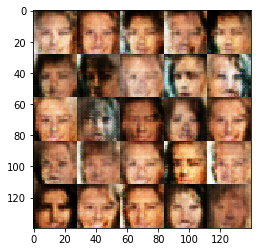

Epoch 1/1... Discriminator Loss: 0.7770... Generator Loss: 1.0049
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 1.2588
Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 1.0541
Epoch 1/1... Discriminator Loss: 0.7768... Generator Loss: 1.4071
Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 1.5669
Epoch 1/1... Discriminator Loss: 0.8843... Generator Loss: 1.4109
Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 1.1409
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 1.3477
Epoch 1/1... Discriminator Loss: 0.8020... Generator Loss: 1.4294


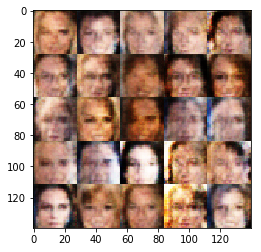

Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 1.3893
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 1.6385
Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 1.3767
Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 2.1734
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 1.5301
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 0.8006... Generator Loss: 0.9808
Epoch 1/1... Discriminator Loss: 0.7686... Generator Loss: 1.9676


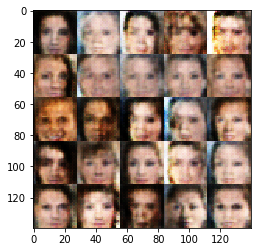

Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 1.0893
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 1.2939
Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 1.1000
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.3873
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 1.8463
Epoch 1/1... Discriminator Loss: 0.7821... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 0.9141
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 0.9501... Generator Loss: 0.7896


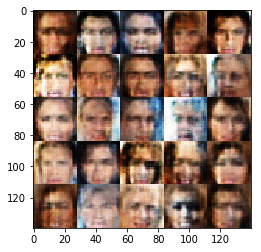

Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 1.2455
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 1.0359
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 0.7856... Generator Loss: 1.3050
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 2.8626
Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.4613
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 1.2207
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.4774
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 1.2509


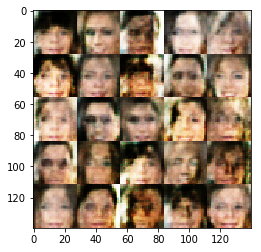

Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 1.1046
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 1.2601
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 0.9192... Generator Loss: 1.7078
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 2.1224
Epoch 1/1... Discriminator Loss: 0.8325... Generator Loss: 1.4442
Epoch 1/1... Discriminator Loss: 0.7652... Generator Loss: 1.4307
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 0.5213
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.2096


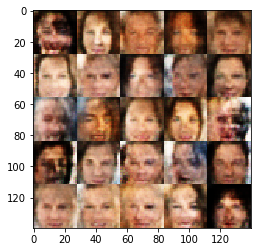

Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 0.6692... Generator Loss: 1.1566
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 0.9188... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 1.4394
Epoch 1/1... Discriminator Loss: 0.8869... Generator Loss: 1.8117
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 1.4709
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 0.7623... Generator Loss: 1.5692


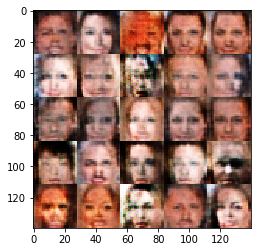

Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 1.6171
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 0.8387... Generator Loss: 1.1375
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 0.9065... Generator Loss: 2.3236
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 1.9593
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 0.8792... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 0.7410... Generator Loss: 1.3326


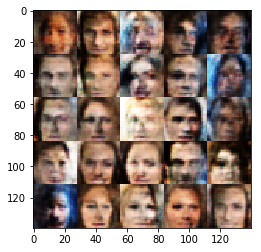

Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 1.4999
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.1859
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 0.7562... Generator Loss: 1.1909
Epoch 1/1... Discriminator Loss: 0.8734... Generator Loss: 1.1386
Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 1.2833
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 1.0761
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.4068


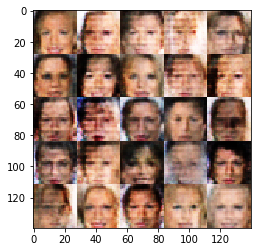

Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 0.8994... Generator Loss: 0.9092
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.3413
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 1.1047
Epoch 1/1... Discriminator Loss: 0.8559... Generator Loss: 1.1739
Epoch 1/1... Discriminator Loss: 1.7360... Generator Loss: 0.2735
Epoch 1/1... Discriminator Loss: 0.8511... Generator Loss: 1.5131
Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 0.9422
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.4964


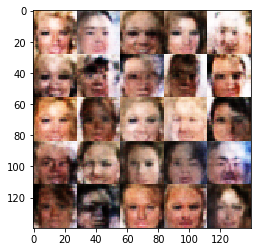

Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 1.4664
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 2.2656
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 1.0753
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.5200
Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 1.3095
Epoch 1/1... Discriminator Loss: 0.8957... Generator Loss: 1.5758
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 1.1297
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.2793


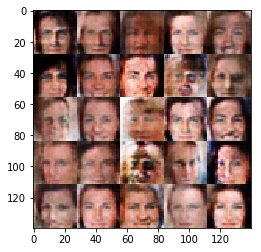

Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 0.6940... Generator Loss: 1.6806
Epoch 1/1... Discriminator Loss: 0.8415... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.3872
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 1.3448
Epoch 1/1... Discriminator Loss: 0.8156... Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 2.0029
Epoch 1/1... Discriminator Loss: 0.8247... Generator Loss: 1.6444
Epoch 1/1... Discriminator Loss: 0.8718... Generator Loss: 0.9805


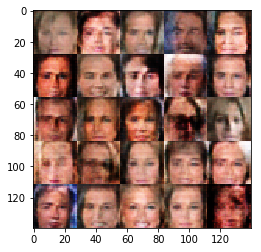

Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.4159
Epoch 1/1... Discriminator Loss: 0.7270... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 0.6659... Generator Loss: 1.5574
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 1.6581
Epoch 1/1... Discriminator Loss: 0.7159... Generator Loss: 1.5605
Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 1.4974
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.5134


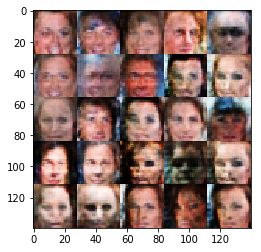

Epoch 1/1... Discriminator Loss: 0.8877... Generator Loss: 1.3881
Epoch 1/1... Discriminator Loss: 0.7158... Generator Loss: 1.8629
Epoch 1/1... Discriminator Loss: 0.8868... Generator Loss: 1.0243
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.4716
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 0.7459... Generator Loss: 1.3817
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 0.9986... Generator Loss: 1.2610


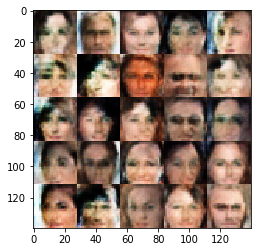

Epoch 1/1... Discriminator Loss: 0.9887... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 1.1173
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 1.4458
Epoch 1/1... Discriminator Loss: 0.7307... Generator Loss: 1.4281
Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 0.8637... Generator Loss: 0.9269
Epoch 1/1... Discriminator Loss: 0.7241... Generator Loss: 1.2956
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 1.7765


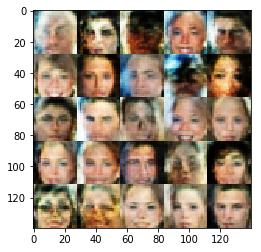

Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 0.7431... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 0.8218... Generator Loss: 1.1195
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 0.8349... Generator Loss: 1.1189
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 2.1887
Epoch 1/1... Discriminator Loss: 0.8004... Generator Loss: 1.1538
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 0.9079


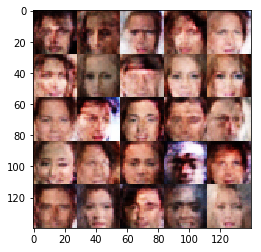

Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 1.2812
Epoch 1/1... Discriminator Loss: 0.7221... Generator Loss: 1.4336
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 1.3586
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 2.7451
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.4705
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 0.8931


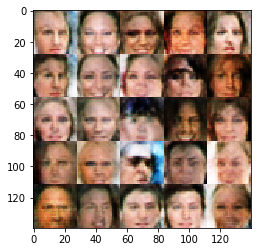

Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.3714
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 1.3384
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 1.0919
Epoch 1/1... Discriminator Loss: 1.7990... Generator Loss: 2.6854
Epoch 1/1... Discriminator Loss: 0.7140... Generator Loss: 1.3537
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 1.0564
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.5763
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.5951


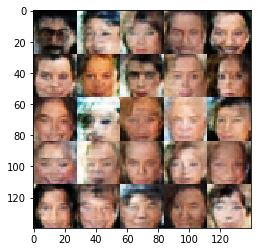

Epoch 1/1... Discriminator Loss: 0.8162... Generator Loss: 1.3459
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 1.5510
Epoch 1/1... Discriminator Loss: 0.8250... Generator Loss: 1.5768
Epoch 1/1... Discriminator Loss: 0.7866... Generator Loss: 1.6468
Epoch 1/1... Discriminator Loss: 0.8789... Generator Loss: 1.1585
Epoch 1/1... Discriminator Loss: 0.6938... Generator Loss: 1.4221
Epoch 1/1... Discriminator Loss: 0.8362... Generator Loss: 1.7427
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 1.2331
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.4875


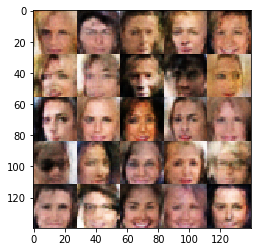

Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 1.5561
Epoch 1/1... Discriminator Loss: 0.6960... Generator Loss: 1.3284
Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 1.5955
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.3635
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 2.0391
Epoch 1/1... Discriminator Loss: 0.8180... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 1.0439
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 1.1638
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 1.2830


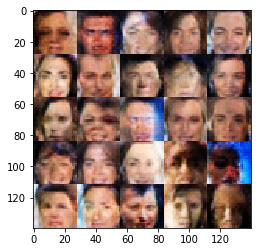

Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 1.3716
Epoch 1/1... Discriminator Loss: 0.9549... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 1.1832
Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 1.4420
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 0.6213


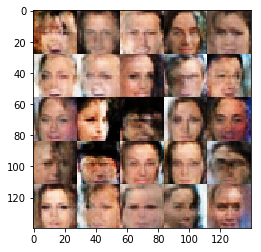

Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 0.9467
Epoch 1/1... Discriminator Loss: 0.7670... Generator Loss: 1.1795
Epoch 1/1... Discriminator Loss: 0.8387... Generator Loss: 1.5477
Epoch 1/1... Discriminator Loss: 0.9394... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 1.0504
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 1.2549


In [13]:
"""
batch_size = None
z_dim = None
learning_rate = None
beta1 = None
"""

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.